# Inference of genus-level microbial interactions

Author: Monica R. Ticlla Ccenhua <br>
e-mail: mticlla@gmail.com monicaroxana.ticllaccenhua@unibas.ch

**Summary**

To infer associations among taxa, we created genus-level and species-level interaction networks with SParse InveresE Covariance Estimation for Ecological ASociation Inference (SPIEC-EASI); available as an R package (_SpiecEasi_). SPIEC-EASI uses CLR-transformed abundances to infer a graph model where nodes represent taxa and edges represent associations between taxa that cannot be explained by alternative paths in the graph <cite data-cite="2542765/2GNQQCBM"></cite>. We selected the neighborhood selection method of SPIEC-EASI. To infer species-level interaction networks, we used the WMS-S taxonomic profiles and considered only those species present in at least 3 samples. To infer genus-level interaction networks, we used the 16S-AS taxonomic profiles and considered only those genera present in at least 5\% of the samples included in the dataset; genera are more likely to be shared across samples, thus we increased the presence threshold.

This notebooks presents the inference of genus-level interactions.

In [1]:
report_date = %env REPORT_DATE
print(report_date)

2020-07-16


## 0. Set-up working environment

**Set-up working directory**

In [2]:
%%capture
cd ../

**Import python modules**

In [3]:
%load_ext rpy2.ipython

.Rprofile: Setting Swiss repository



**Import R packages**

In [4]:
%%capture
%%R
library(phyloseq)
library(ggplot2)
library(hrbrthemes)
hrbrthemes::import_roboto_condensed()
library(RColorBrewer)
library(grid)
library(gridExtra)
library(zCompositions)
library(factoextra)
library(vegan)
library(ggpubr)
library(ggrepel)
library("scales")
library(SpiecEasi)

options("width"=200)

## 1. Input files

### 1.1 16S-AS taxonomic profiles

**Taxonomy table**

In [5]:
%%R
# Loading the taxonomy table
# --------------------------
#' Convert taxonomy table produced by QIIME2 to a 7-ranks data frame
#'
#' @param qiime2_taxonomy A data frame with columns c('Taxon', 'Confidence')
#' @return The taxonomy table as dataframe with seven columns, the seven taxonomic ranks.
qiime2taxonomy_to_df <- function(qiime2_taxonomy){
    features_ids <- rownames(qiime2_taxonomy)
    taxon_ranks_n = 7
    taxon_rank_names = c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
    taxonomies = sapply(qiime2_taxonomy$Taxon, 
                        function(x,nranks){
                            taxonomy_vector = strsplit(x,'; ')[[1]]
                            na_vector = rep(NA,nranks-length(taxonomy_vector))
                            c(taxonomy_vector,na_vector)}, 
                        taxon_ranks_n)
    taxonomies = data.frame(matrix(taxonomies, 
                                   nrow=length(features_ids), 
                                   ncol=taxon_ranks_n, byrow=TRUE), 
                            row.names=features_ids, 
                            stringsAsFactors=FALSE)
    colnames(taxonomies) <- taxon_rank_names
    return(taxonomies)
}

# Load taxonomies
asv16s_taxonomy_table_file <- './data/interim/QIIME2/tz_spt_cases_fwd/artifacts/taxonomy/exported/taxonomy.tsv'
asv16s_taxonomy_table <- read.table(asv16s_taxonomy_table_file, header=TRUE, sep='\t', stringsAsFactors=FALSE, 
                                    quote="", check.names=FALSE, row.names=1)
asv16s_taxonomy_table <- qiime2taxonomy_to_df(asv16s_taxonomy_table)
print(dim(asv16s_taxonomy_table))
print(asv16s_taxonomy_table[0:3,0:3])

cat("\nNr of ASVs: ")
cat(dim(asv16s_taxonomy_table)[1])

cat("\nNr of taxonomic levels: ")
cat(dim(asv16s_taxonomy_table)[2])

# Re-format taxonomy table for phyloseq
# Replace non-assigned taxonomy ranks(e.g p__) with NA
is_undefined_rank <- t(unlist(apply(asv16s_taxonomy_table, 1, 
                                    function(x){x %in% c("k__","p__","c__","o__","f__","g__","s__")})))
asv16s_taxonomy_table_ps <- asv16s_taxonomy_table
asv16s_taxonomy_table_ps[ is_undefined_rank ] <- NA


[1] 28284     7
                                     Kingdom           Phylum          Class
0000134bb4f9a56941dd1d0206a600d8 k__Bacteria p__Bacteroidetes c__Bacteroidia
00032a9354651fef5c866ec3f9cdca0d k__Bacteria p__Bacteroidetes c__Bacteroidia
000374910b98b14cc5724af75f294b87 k__Bacteria p__Bacteroidetes c__Bacteroidia

Nr of ASVs: 28284
Nr of taxonomic levels: 7

**Abundance table**

In [6]:
%%R
# Loading the feature table
# -------------------------
asv16s_qiime2_feature_table_file <- "./data/interim/QIIME2/tz_spt_cases_fwd/artifacts/decontam/decontam_table.tsv"
asv16s_qiime2_feature_table <- read.table(asv16s_qiime2_feature_table_file, header=TRUE, sep='\t', 
                                          stringsAsFactors=FALSE, quote = "", check.names=FALSE, row.names=1, 
                                          comment.char="", skip=1)

print(asv16s_qiime2_feature_table[0:3,0:3])

# Create phyloseq object
# ----------------------
# Lets create the phyloseq object (feature/otu table and taxonomy tables merged)
asv16s_feature_table_ps <- phyloseq(otu_table(asv16s_qiime2_feature_table, 
                                              taxa_are_rows=TRUE), 
                                    tax_table(as.matrix(asv16s_taxonomy_table_ps)))
print(asv16s_feature_table_ps)


# Remove samples with less than 12000 total reads
asv16s_feature_table_ps <- prune_samples(sample_sums(asv16s_feature_table_ps) >=12000, 
                                         asv16s_feature_table_ps)

# remove ASV with abundance zero
asv16s_feature_table_ps = filter_taxa(asv16s_feature_table_ps, function(x){sum(x) > 0}, TRUE)

cat("\nContent of Phyloseq object: \n")
print(asv16s_feature_table_ps)

                                 A00030 A00034 A00036
0000134bb4f9a56941dd1d0206a600d8      0      0      0
00032a9354651fef5c866ec3f9cdca0d      0      0      0
000374910b98b14cc5724af75f294b87      0      0      0
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 28274 taxa and 335 samples ]
tax_table()   Taxonomy Table:    [ 28274 taxa by 7 taxonomic ranks ]

Content of Phyloseq object: 
phyloseq-class experiment-level object
otu_table()   OTU Table:         [ 27668 taxa and 307 samples ]
tax_table()   Taxonomy Table:    [ 27668 taxa by 7 taxonomic ranks ]


**Sequencing summaries**

In [7]:
%%R
asv16s_stats_file <- "./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/denoised/denoising-stats_run123.tsv"
asv16s_stats <- read.csv(asv16s_stats_file, sep="\t", header=TRUE, row.names=1)
print(head(asv16s_stats))
cat("\nNr of samples: ")
cat(dim(asv16s_stats)[1])

cat("\n---\n")
cat("Total retained: \n")
cat(sum(asv16s_stats$non.chimeric))

       input filtered denoised non.chimeric perc_kept
A00030 69471    35777    33346        23903  34.40716
A00034 46103    25102    24765        19104  41.43765
A00036 59728    34850    34422        26914  45.06094
A00038 53641    29543    28367        17434  32.50126
A00053   440      121       49           49  11.13636
A00056 35483    18274    17893        15719  44.30009

Nr of samples: 335
---
Total retained: 
12384275

### 1.2 WMS-S taxonomic profiles

In [8]:
%%R
# Load taxonomic abundance profiles (relative abundances)
wms_abundance_table_file <- "./data/interim/MetaSnk/wms_cases/PhlAnProf/metaphlan/profiles_merged/wms_cases_abundances_table.txt"
wms_abundance_table <- read.table(wms_abundance_table_file, header=TRUE, sep='\t', 
                                  stringsAsFactors=FALSE, quote = "", check.names=FALSE, row.names=1)
print(wms_abundance_table[1:5,1:2])
cat("\nDimensions of data before filtering\n")
cat("\nNr of samples: ")
cat(dim(wms_abundance_table)[2])
cat("\nNr of taxa: ")
cat(dim(wms_abundance_table)[1])

# Remove samples with high levels of contaminant spp.
# List of contaminated samples
wms_samples_highcont_file <- "./data/interim/wms_contaminated_samples_ids.tsv"
wms_samples_highcont <- readLines(file(wms_samples_highcont_file))
cat("\n\nNumber of samples highly contaminated: ")
cat(length(wms_samples_highcont))
cat("\nSamples highly contaminated: \n")
print(wms_samples_highcont)
metaphlan_all_spp_contaminated_samples_ix <- which(colnames(wms_abundance_table) %in% wms_samples_highcont)
wms_abundance_table <- wms_abundance_table[,-metaphlan_all_spp_contaminated_samples_ix]
print(dim(wms_abundance_table))

# Remove samples with high percentage of unclassified reads
# Distribution of percentage of "unclassified" reads per sample
cat("\n\nDistribution of percentage of 'unclassified' reads per sample")
print(table(t(wms_abundance_table["unclassified",])))
has_only_unclassified <- as.vector(t(wms_abundance_table["unclassified",])==100)
mp_unclassified_samples <- colnames(wms_abundance_table)[has_only_unclassified]
cat("Samples with only unclassified reads: \n")
cat(colnames(wms_abundance_table)[has_only_unclassified])
wms_abundance_table <- wms_abundance_table[,!has_only_unclassified]

# Remove samples with abnormal percentage of human DNA
wms_stats_file <- "./data/interim/MetaSnk/wms_cases/preQC/summary_stats/wms_cases_preqc_samples_summary.tsv"
wms_stats <- read.table(wms_stats_file, sep="\t", header=TRUE, row.names=1)
cat("\n\nPercent Human: \n")
print(summary(wms_stats$filter_human_pct_disc))
samples_wit_lowpct_human <- rownames(wms_stats)[wms_stats$filter_human_pct_disc<50]
cat("\nSamples with low percentage of human reads (<50%): ",length(samples_wit_lowpct_human), "\n")
cat(samples_wit_lowpct_human)
is_lowpct_human <- colnames(wms_abundance_table) %in% samples_wit_lowpct_human
cat("\nSamples with low percentage of human reads (<50%) not yet removed by previous filters: ",
    sum(is_lowpct_human), "\n")
wms_abundance_table <- wms_abundance_table[,!is_lowpct_human]

# Remove taxa with zero total counts
taxa_has_only_zeros <- rowSums(wms_abundance_table)==0
wms_abundance_table <- wms_abundance_table[!taxa_has_only_zeros,]
cat("\n\nNr of taxa with zero totals: \n")
cat(sum(taxa_has_only_zeros))

cat("\n\nDimensions of data after filtering\n")
cat("\nNr of samples: ")
cat(dim(wms_abundance_table)[2])
cat("\nNr of taxa: ")
cat(dim(wms_abundance_table)[1])

                                                                                          M00186   M00158
k__Bacteria                                                                            100.00000 89.48721
k__Bacteria|p__Actinobacteria                                                           91.74722 36.23369
k__Bacteria|p__Actinobacteria|c__Actinobacteria                                         91.74722 36.23369
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales                      91.74722 36.23369
k__Bacteria|p__Actinobacteria|c__Actinobacteria|o__Actinomycetales|f__Actinomycetaceae   0.00000  0.00000

Dimensions of data before filtering

Nr of samples: 129
Nr of taxa: 1094

Number of samples highly contaminated: 22
Samples highly contaminated: 
 [1] "M00176" "M00161" "M00226" "M00269" "M00081" "M00111" "M00065" "M00084" "M00094" "M00054" "M00219" "M00276" "M00086" "M00135" "M00004" "M00090" "M00229" "M00122" "M00033" "M00001" "M00241"
[22] "M00218"
[1] 1094 

**Split taxon abundances by taxonomic ranks**

In [9]:
%%R
# Taxon IDs per rank
kingdoms <- grep("\\|",rownames(wms_abundance_table), value=TRUE, invert=TRUE)
species_all <- grep("^k__[[:graph:]]*\\|s__[^\\|]*$", rownames(wms_abundance_table), value=TRUE)
cat("\nNr of species: ", length(species_all))

# Remoce Species/strains flagged as contaminants by decontam
# List of potential contamiant spp.
wms_contaminants_ids_file <- "./data/interim/wms_contaminants_decontam.tsv"
wms_contaminants_ids <- read.table(wms_contaminants_ids_file, sep='\t',header=TRUE, stringsAsFactors=FALSE)

species_all <- names(which(sapply(species_all, 
                                   function(x){
                                       if(sum(stringr::str_detect(x,wms_contaminants_ids$sp_id))>0){
                                           FALSE
                                       }else{
                                           TRUE
                                       }
                                   })))
cat("\nNr of species after removing potential contaminants: ", length(species_all))

# Species abundances
# ---------------------
# Relative abundances (%)
wms_all_spp_abund_table <- wms_abundance_table[species_all,]
wms_all_spp_abund_table <- wms_all_spp_abund_table[rowSums(wms_all_spp_abund_table)>0,]
# Relative counts
wms_all_spp_counts_table <- t(apply(wms_all_spp_abund_table,1,
                                   function(x,x_totals){round((x*x_totals)/100)}, 
                                   x_totals=wms_stats[colnames(wms_all_spp_abund_table),"total_kept_reads"]))

# Taxonomy assignment
wms_all_spp_taxonomy <- as.data.frame(do.call(rbind,strsplit(rownames(wms_all_spp_counts_table),"\\|")))
colnames(wms_all_spp_taxonomy) <- c("Kingdom","Phylum","Class","Order","Family","Genus","Species")
rownames(wms_all_spp_taxonomy) <- wms_all_spp_taxonomy$Species

rownames(wms_all_spp_counts_table) <- wms_all_spp_taxonomy$Species
rownames(wms_all_spp_abund_table) <- wms_all_spp_taxonomy$Species


Nr of species:  195
Nr of species after removing potential contaminants:  188

### 1.3 Mode of metabolism for species

In [10]:
%%R
wms_spp_metabolism_req_file <- "./data/raw/metadata/species_oxygen_tolerance.csv"
wms_spp_metabolism_req <- read.table(wms_spp_metabolism_req_file, header=TRUE, sep='\t', 
                                     stringsAsFactors=FALSE, quote="", check.names=FALSE, row.names=1)
head(wms_spp_metabolism_req)

                            oxygen_requirement     gram                          reference
Actinomyces_cardiffensis              anaerobe positive https://bacdive.dsmz.de/strain/184
Actinomyces_graevenitzii  Facultative anaerobe positive https://bacdive.dsmz.de/strain/186
Actinomyces_johnsonii                 anaerobe positive https://bacdive.dsmz.de/strain/190
Actinomyces_massiliensis              anaerobe positive https://bacdive.dsmz.de/strain/192
Actinomyces_naeslundii                anaerobe positive https://bacdive.dsmz.de/strain/154
Actinomyces_odontolyticus             anaerobe positive https://bacdive.dsmz.de/strain/155


### 1.4 Faith's phylogenetic diversity estimation

In [11]:
%%R
faithpd_file <- "./data/interim/QIIME2/tz_spt_cases_fwd/visualizations/rarefaction/faith-pd_12k_rarefied/faith_pd.csv"
faithpd_table <- na.omit(read.table(faithpd_file, sep=',', header=TRUE, row.names=1,
                          na.strings = c('.',' ',''))[-2])
head(faithpd_table)

       depth.12000_iter.1
A00030          26.216870
A00034           6.370249
A00036          10.413151
A00038          13.682772
A00056          17.685786
A00059          17.060311


### 1.4 Host and sample metadata

**Host's clinical data**

In [12]:
%%R
# Load samples metadata
#-----------------------
sample_medatata_file <- './data/interim/host_metadata_extended.tsv'
sample_metadata <- read.table(sample_medatata_file, sep='\t', header=TRUE, row.names=1, 
                              na.strings = c('.',' ','','NA','<NA>'))

## Define the levels of categorical variables:
delaymedtp_cat2_levels <- c('no','amoxycillin','amoxycillin+ampicillin','amoxycillin+cloxacillin',
                            'amoxycillin+ampicillin+cloxacillin','other-medications')
sample_metadata$delaymedtp_cat2 <- factor(sample_metadata$delaymedtp_cat2, levels=delaymedtp_cat2_levels)
print(summary(sample_metadata$delaymedtp_cat2), nrows=2)

delaymed_3cat_levels <- c('No','Penicillins','Other')
sample_metadata$delaymed_3cat <- factor(sample_metadata$delaymed_3cat, levels=delaymed_3cat_levels)
print(summary(sample_metadata$delaymed_3cat))

sample_metadata$smear_grading_bin <- factor(sample_metadata$smear_grading_bin, levels=c('Low','High'))
print(summary(sample_metadata$smear_grading_bin))

xraysevere.levels                 <- c("Normal", "Mild/moderate", "Severe")
sample_metadata$xraysevere        <- factor(sample_metadata$xraysevere, 
                                            levels = xraysevere.levels, ordered=TRUE)
print(summary(sample_metadata$xraysevere))

tbscore_bin.levels                <- c("Mild", "Severe")
sample_metadata$tbscore_bin       <- factor(sample_metadata$tbscore_bin, 
                                            levels = tbscore_bin.levels, ordered=TRUE)
print(summary(sample_metadata$tbscore_bin))

age.levels                        <- c("<25", "25-34", "35-44", ">44")
sample_metadata$age_cat           <- factor(sample_metadata$age_cat, levels=age.levels)
print(summary(sample_metadata$age_cat))

#sex.levels                        <- c("male","female")
sex.levels                        <- c("Male","Female")
sample_metadata$male              <- factor(sample_metadata$male, levels = sex.levels)
print(summary(sample_metadata$male))

#bmi_cat.levels                    <- c("BMI >=18.5", "BMI <18.5")
bmi_cat.levels                    <- c("Normal/Obese BMI>=18.5", "Underweight BMI<18.5")
sample_metadata$bmi_cat           <- factor(sample_metadata$bmi_cat, 
                                            levels = bmi_cat.levels)
print(summary(sample_metadata$bmi_cat))

#season.levels                     <- c("Short Rain", "Long Rain", "Dry")
season.levels                     <- c("Short Rains (Oct. - Feb.)", "Long Rains (March - May)", "Dry (June - Sept.)")
sample_metadata$season            <- factor(sample_metadata$season, levels = season.levels)
print(summary(sample_metadata$season))

# CXR lesions
cavitation.levels           <- c("Absent","Present")
sample_metadata$caviation   <- factor(sample_metadata$caviation, levels=cavitation.levels, ordered=FALSE)
print(summary(sample_metadata$caviation))

infiltration.levels           <- c("Absent","Present")
sample_metadata$filtration   <- factor(sample_metadata$filtration, levels=infiltration.levels, ordered=FALSE)
print(summary(sample_metadata$filtration))

effusion.levels           <- c("Absent","Present")
sample_metadata$effusion   <- factor(sample_metadata$effusion, levels=effusion.levels, ordered=FALSE)
print(summary(sample_metadata$effusion))

lymphnode.levels           <- c("Absent","Present")
sample_metadata$lymphnode   <- factor(sample_metadata$lymphnode, levels=lymphnode.levels, ordered=FALSE)
print(summary(sample_metadata$lymphnode))

micronode.levels           <- c("Absent","Present")
sample_metadata$micronode   <- factor(sample_metadata$micronode, levels=micronode.levels, ordered=FALSE)
print(summary(sample_metadata$micronode))

anemia_levels <- c('No anemia','Mild','Moderate','Severe')
sample_metadata$anemia_status <- factor(sample_metadata$anemia_status, levels=anemia_levels, ordered=TRUE)
print(summary(sample_metadata$anemia_status))

sample_metadata$anemia_bin <- factor(sample_metadata$anemia_bin, levels=c("No","Yes"))
print(summary(sample_metadata$anemia_bin))

nutritional_status_levels <- c('Normal weight','Underweight','Obesity')
sample_metadata$nutrition_status <- factor(sample_metadata$nutrition_status, levels=nutritional_status_levels, 
                                           ordered=FALSE)
print(summary(sample_metadata$nutrition_status))

sample_metadata$xray_findings <- factor(sample_metadata$xray_findings, levels=c("Normal","Abnormal"))
print(summary(sample_metadata$xray_findings))

#cxr_categories_levels <- c("Normal","filtration","filtration_cavitation","filtration_other","effusion","other")
cxr_categories_levels <- c("Normal","Infiltration","Infiltration & Cavitation","Infiltration (other)","Pleural effusion","Other")
sample_metadata$cxr_categories <- factor(sample_metadata$cxr_categories, levels=cxr_categories_levels)
print(summary(sample_metadata$cxr_categories))

sample_metadata$lineage134 <- factor(sample_metadata$lineage134, levels=c('L3','L1','L4'))
print(summary(sample_metadata$lineage134))

cat("\n Number of samples in dataset: ")
cat(dim(sample_metadata)[1])
cat("\n Number of variables in dataset: ")
cat(dim(sample_metadata)[2])

                                no                        amoxycillin             amoxycillin+ampicillin            amoxycillin+cloxacillin amoxycillin+ampicillin+cloxacillin 
                                20                                 31                                 90                                 47                                 96 
                 other-medications 
                                50 
         No Penicillins       Other 
         20         264          50 
 Low High 
 127  207 
       Normal Mild/moderate        Severe          NA's 
           59           132            56            87 
  Mild Severe 
   223    111 
  <25 25-34 35-44   >44 
   61   129    95    49 
  Male Female 
   240     94 
Normal/Obese BMI>=18.5   Underweight BMI<18.5 
                   158                    176 
Short Rains (Oct. - Feb.)  Long Rains (March - May)        Dry (June - Sept.)                      NA's 
                      120                        74      

**Table with mapping IDs**

In [13]:
%%R
asv16s_mapping_ids_file <- "./data/raw/tz_spt_cases/sample_ids_mapping.txt"
wms_mapping_ids_file <- "data/raw/wms/wms_cases/sample_ids_mapping.txt"

asv16s_mapping_ids <- read.table(asv16s_mapping_ids_file, header=TRUE, sep='\t',
                                 stringsAsFactors=FALSE, row.names=1)
wms_mapping_ids <- read.table(wms_mapping_ids_file, header=TRUE, sep='\t',
                                 stringsAsFactors=FALSE, row.names=1, na.strings = c("NA",""))

print(head(asv16s_mapping_ids, n=3))
print(head(wms_mapping_ids, n=3))

       SpecimenID SubjectID seq_run
A00030     S00394    H00388    run1
A00034     S00426    H00421    run1
A00036     S00173    H00173    run1
       SpecimenID SubjectID
M00001     S00181    H00183
M00002     S00375    H00368
M00004        NC3      <NA>


## 2 Identification of genus-level interactions using compositional data analysis on 16S-AS taxonomic profiles

### 2.1 Extract genus-level abundances

In [14]:
%%R

# Extract counts
# ---------------
asv16s_bacteria_genus_counts_ps <- tax_glom(subset_taxa(asv16s_feature_table_ps, Kingdom=="k__Bacteria"), 
                                            "Genus", NArm=FALSE)

# Extract relative abundances
# ---------------------------
asv16s_bacteria_genus_ra <- otu_table(transform_sample_counts(asv16s_bacteria_genus_counts_ps,
                                                              function(x){(x/sum(x))*100}))
asv16s_bacteria_genus_ra <- t(asv16s_bacteria_genus_ra)
print(head(asv16s_bacteria_genus_ra))

OTU Table:          [522 taxa and 6 samples]
                     taxa are columns
       00054bda86b78c430a861fa6dbd577f9 005437e2403405bc5930d766a3a9a44d 0054e5be5a0d5094620e9bcc93ec8207 005d8a7030eb05c419b56514e7157ed4 00ffa6dec3ed0e17e1ffe754cdb8c629
A00030                        0.0334686                                0                                0                                0                        0.0334686
A00034                        0.0000000                                0                                0                                0                        0.0000000
A00036                        0.0000000                                0                                0                                0                        0.0000000
A00038                        0.0000000                                0                                0                                0                        0.0000000
A00056                        0.0000000                  

### 2.2 Centred-log ratio (CLR) transformation of abundances

In [17]:
%%R
# CLR-transformation of counts
# ----------------------------
asv16s_bacteria_genus_counts_clr <-  otu_table(asv16s_bacteria_genus_counts_ps)

# Filter rare genus
# Keep those which are at least 5% prevalent in the dataset
prevalence_cutoff <- round(5*(dim(asv16s_bacteria_genus_counts_clr)[2])/100)
cat("\nPrevalence cut-off: ")
cat(prevalence_cutoff)
genus_is_abv_cutoff <- as.vector(rowSums(asv16s_bacteria_genus_counts_clr>0) >= prevalence_cutoff)
asv16s_bacteria_genus_counts_clr <- asv16s_bacteria_genus_counts_clr[genus_is_abv_cutoff,]

# Remove samples with zero totals
sample_has_zero_totals <- as.vector(colSums(asv16s_bacteria_genus_counts_clr)==0)
if(sum(sample_has_zero_totals)>0){
    cat("\nSamples with zero totals removed: ")
    cat(colnames(asv16s_bacteria_genus_counts_clr)[sample_has_zero_totals])
    asv16s_bacteria_genus_counts_clr <- asv16s_bacteria_genus_counts_clr[,!sample_has_zero_totals]
}
cat("\nDimensions(genera-by-samples) of filtered table: ",
    dim(asv16s_bacteria_genus_counts_clr),'\n')

# Then, replace zeroes, returns a sample-by-features table (samples as rows)
asv16s_bacteria_genus_counts_clr <- cmultRepl(t(asv16s_bacteria_genus_counts_clr), 
                                              label=0, method="CZM", output="p-counts")
# Finally, apply CLR-transformation
asv16s_bacteria_genus_counts_clr <- t(apply(asv16s_bacteria_genus_counts_clr, 1, 
                                            function(x){log(x) - mean(log(x))}))
print(asv16s_bacteria_genus_counts_clr[1:5,1:2])


Prevalence cut-off: 15
Dimensions(genera-by-samples) of filtered table:  147 307 
No. corrected values:  1575 
       00054bda86b78c430a861fa6dbd577f9 00ffa6dec3ed0e17e1ffe754cdb8c629
A00030                        0.9746196                        0.9746196
A00034                       -0.6501133                       -0.6501133
A00036                       -1.1481609                       -1.1481609
A00038                       -1.7419236                       -1.2766701
A00056                       -2.2738214                       -1.7088573


### 2.3 Compositional biplots

**Principal component analysis (PCA) on CLR-transformed values**

In [18]:
%%R -w 800 -h 800 -u px

BREWER_COLS <- brewer.pal(3, "YlGnBu")
COLOR_INTERPOLATOR <- colorRampPalette(BREWER_COLS)

# Extract genus names
# --------------------
genus_name <- data.frame(tax_table(asv16s_bacteria_genus_counts_ps)[colnames(asv16s_bacteria_genus_counts_clr),
                                                                    "Genus"], 
                         stringsAsFactors=FALSE)
# Some will be NAs, we add a renamed version that includes the family names or above rank if NA
genus_name$label <- unlist(lapply(as.character(rownames(genus_name)), 
                                         function(x){
                                             genus_name <- tax_table(asv16s_bacteria_genus_counts_ps)[x,"Genus"]; 
                                             family_name <- tax_table(asv16s_bacteria_genus_counts_ps)[x,"Family"]; 
                                             order_name <- tax_table(asv16s_bacteria_genus_counts_ps)[x,"Order"];
                                             if(is.na(genus_name) && is.na(family_name)){
                                                 paste(order_name,"NA; NA", sep='; ')
                                             }else if(is.na(genus_name)){
                                                 paste(family_name,"NA", sep='; ')
                                             }else{
                                                 genus_name
                                             }}))
genus_name$label <- paste(seq(1,dim(genus_name)[1]), genus_name$label, sep='.')

streptococcus_id <- rownames(genus_name)[which(genus_name$Genus == "g__Streptococcus")]
neisseria_id <- rownames(genus_name)[which(genus_name$Genus == "g__Neisseria")]
selenomonas_id <- rownames(genus_name)[which(genus_name$Genus == "g__Selenomonas")]

# Principal component analysis (PCA) on CLR-transformed values
# --------------------------------------------------------------
asv16s_bactGenera_pca <- prcomp(asv16s_bacteria_genus_counts_clr,  center=TRUE, scale=FALSE)

asv16s_bactGenera_pca_legend <- expression(paste("log(", 
                                                 frac("g__Streptococcus (%)","g__Selenomonas (%)"),")"))

rownames(asv16s_bactGenera_pca$rotation) <- genus_name$label

**Compositional biplot with samples colored by phylogenetic diversity**

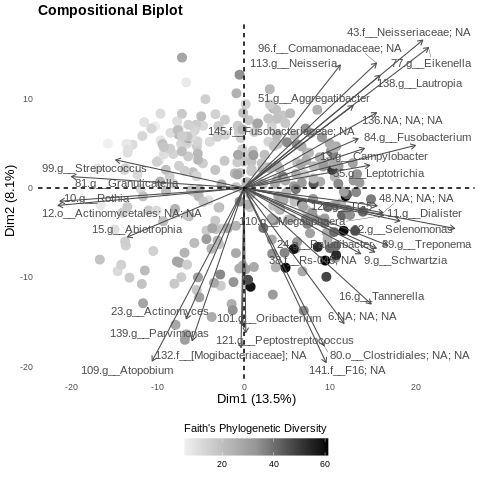

In [19]:
%%R
# Compositional biplot
asv16s_bactGenera_pca_biplot <- fviz_pca_biplot(asv16s_bactGenera_pca, 
                                                # Individuals
                                                col.ind=faithpd_table[rownames(asv16s_bacteria_genus_counts_clr),],
                                                geom.ind="point", pointsize = 4,
                                                gradient.cols = c("#f0f0f0","#969696","#000000"), 
                                                repel=TRUE,
                                                label ="var", 
                                                select.var=list(cos2=35),
                                                col.var="#4d4d4d",
                                                title = "Compositional Biplot",
                                                legend.title = "Faith's Phylogenetic Diversity"
                                               ) +
                                    theme_minimal() + 
                                    theme(plot.title = element_text(face="bold", hjust=0,size=14), 
                                          axis.title=element_text(size=13),
                                          panel.grid.major = element_blank(), 
                                          panel.grid.minor = element_blank(),
                                          legend.position="bottom") +
                                    guides(colour=guide_colourbar(title.position="top", barwidth=10))

asv16s_bactGenera_pca_biplot

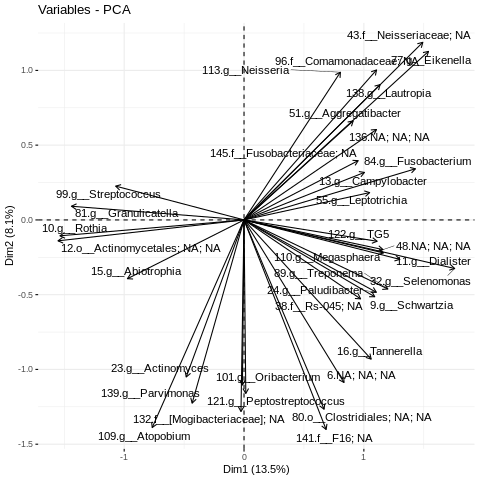

In [20]:
%%R
asv16s_bactGenera_pca_vars_plot <- fviz_pca_var(asv16s_bactGenera_pca, label="var", 
                                                axes = c(1, 2),
                                                select.var=list(cos2=35),
                                                repel=TRUE
                                               )
asv16s_bactGenera_pca_vars_plot

**Compositional biplot with samples colored by relative abundance of genus _Streptococcus_**

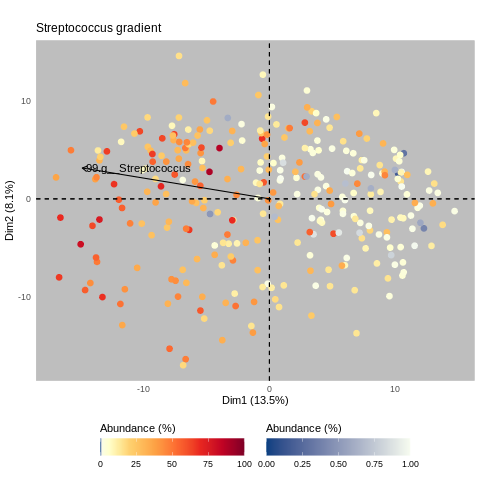

In [21]:
%%R
# PCA biplot, streptococcus gradient
color_palette_reds <- colorRampPalette(brewer.pal(9, "YlOrRd"))
color_palette_blues <- colorRampPalette(c("#f7fcf0", "#084081"))

asv16s_bacteria_genus_ra_strepto <- as.vector(asv16s_bacteria_genus_ra[rownames(asv16s_bacteria_genus_counts_clr),
                                                                       streptococcus_id])

asv16s_bactGenera_pca_biplot_ra_strepto <- fviz_pca_biplot(asv16s_bactGenera_pca, 
                                                           # Individuals
                                                           fill.ind=asv16s_bacteria_genus_ra_strepto,
                                                           col.ind=asv16s_bacteria_genus_ra_strepto,
                                                           geom.ind="point", pointsize = 2.5, 
                                                           repel=TRUE,
                                                           label ="var", 
                                                           select.var=list(name=genus_name[streptococcus_id,"label"]),
                                                           col.var="black", title="",
                                                           subtitle = "Streptococcus gradient",
                                                           legend.title = "Abundance (%)"
                                                          ) +
                                            scale_colour_gradientn(colours = c("#084081","#f7fcf0",color_palette_reds(8)),
                                                                   values=rescale(c(0,1,10,20,40,60,80,100)),
                                                                   limits=c(0,100)) +
                                            scale_fill_gradientn(colours=c("#084081","#f7fcf0"), 
                                                                 values=rescale(c(0,1)), limits=c(0,1)) +
                                            theme_minimal() + 
                                            theme(plot.subtitle = element_text(hjust=0,size=12),
                                                  panel.grid.major = element_blank(), 
                                                  panel.grid.minor = element_blank(),
                                                  legend.position="bottom", 
                                                  panel.background=element_rect(fill = "grey", colour="grey", size = 0.5)) +
                                            guides(colour=guide_colourbar(title.position="top", barwidth=10), 
                                                   fill=guide_colourbar(title.position="top", barwidth=10))

asv16s_bactGenera_pca_biplot_ra_strepto

**Compositional biplot with samples colored by relative abundance of genus _Neisseria_**

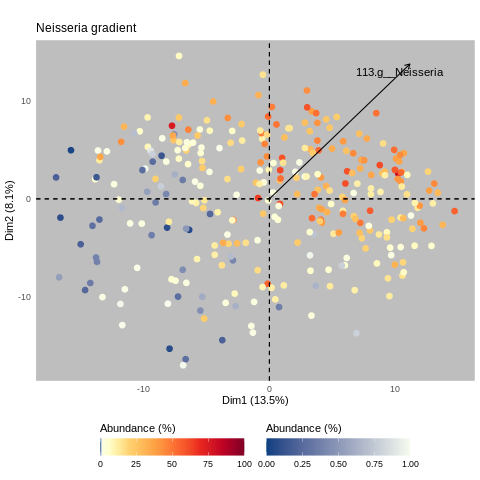

In [22]:
%%R
# PCA biplot, Neisseria gradient
asv16s_bacteria_genus_ra_neisseria <- as.vector(asv16s_bacteria_genus_ra[rownames(asv16s_bacteria_genus_counts_clr),
                                                                         neisseria_id])

asv16s_bactGenera_pca_biplot_ra_neisser <- fviz_pca_biplot(asv16s_bactGenera_pca, 
                                                           # Individuals
                                                           fill.ind=asv16s_bacteria_genus_ra_neisseria,
                                                           col.ind=asv16s_bacteria_genus_ra_neisseria,
                                                           geom.ind="point", pointsize = 2.5, 
                                                           repel=TRUE,
                                                           label ="var", 
                                                           select.var=list(name=genus_name[neisseria_id,"label"]),
                                                           col.var="black", title="",
                                                           subtitle = "Neisseria gradient",
                                                           legend.title = "Abundance (%)"
                                                          ) +
                                            scale_colour_gradientn(colours = c("#084081","#f7fcf0",color_palette_reds(8)),
                                                                   values=rescale(c(0,1,10,20,40,60,80,100)),
                                                                   limits=c(0,100)) +
                                            scale_fill_gradientn(colours=c("#084081","#f7fcf0"), 
                                                                 values=rescale(c(0,1)), limits=c(0,1)) +
                                            theme_minimal() + 
                                            theme(plot.subtitle = element_text(hjust=0,size=12),
                                                  panel.grid.major = element_blank(), 
                                                  panel.grid.minor = element_blank(),
                                                  legend.position="bottom",
                                                  panel.background=element_rect(fill = "grey", colour="grey", size = 0.5)) +
                                            guides(colour=guide_colourbar(title.position="top", barwidth=10), 
                                                   fill=guide_colourbar(title.position="top", barwidth=10))

asv16s_bactGenera_pca_biplot_ra_neisser

**Compositional biplot with samples colored by relative abundance of genus _Selenomonas_**

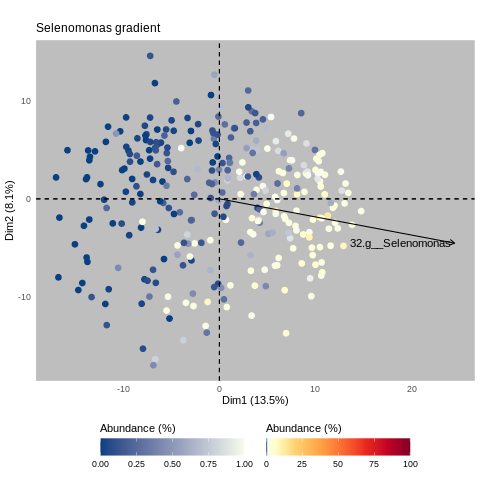

In [23]:
%%R
# PCA biplot, Selenomonas gradient
asv16s_bacteria_genus_ra_neisseria <- as.vector(asv16s_bacteria_genus_ra[rownames(asv16s_bacteria_genus_counts_clr),
                                                                         selenomonas_id])

asv16s_bactGenera_pca_biplot_ra_selenom <- fviz_pca_biplot(asv16s_bactGenera_pca, 
                                                           # Individuals
                                                           fill.ind=asv16s_bacteria_genus_ra_neisseria,
                                                           col.ind=asv16s_bacteria_genus_ra_neisseria,
                                                           geom.ind="point", pointsize = 2.5, 
                                                           repel=TRUE,
                                                           label ="var", 
                                                           select.var=list(name=genus_name[selenomonas_id,"label"]),
                                                           col.var="black", title="",
                                                           subtitle = "Selenomonas gradient",
                                                           legend.title = "Abundance (%)"
                                                          ) +
                                            scale_colour_gradientn(colours = c("#084081","#f7fcf0",color_palette_reds(8)),
                                                                   values=rescale(c(0,1,10,20,40,60,80,100)),
                                                                   limits=c(0,100)) +
                                            scale_fill_gradientn(colours=c("#084081","#f7fcf0"), 
                                                                 values=rescale(c(0,1)), limits=c(0,1)) +
                                            theme_minimal() + 
                                            theme(plot.subtitle = element_text(hjust=0,size=12),
                                                  panel.grid.major = element_blank(), 
                                                  panel.grid.minor = element_blank(),
                                                  legend.position="bottom", 
                                                  panel.background=element_rect(fill = "grey", colour="grey", size = 0.5)) +
                                            guides(colour=guide_colourbar(order=0,title.position="top", barwidth=10), 
                                                   fill=guide_colourbar(order=1,title.position="top", barwidth=10))

asv16s_bactGenera_pca_biplot_ra_selenom

**Compositional biplot panel**

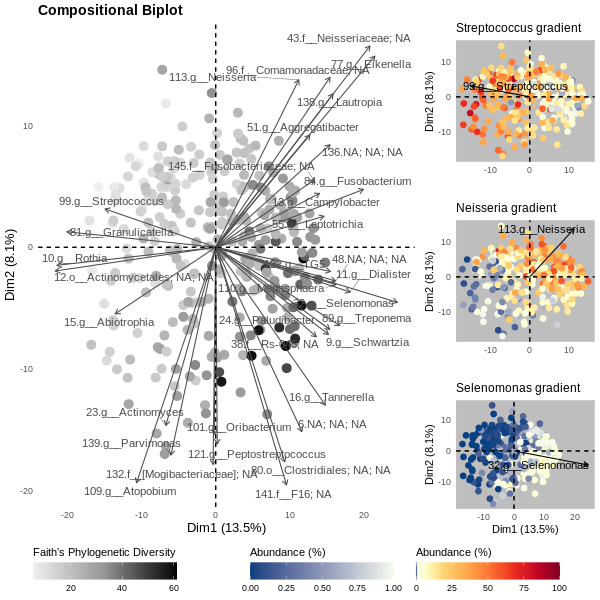

In [24]:
%%R -w 600 -h 600 -u px
biplot_faith_legend <- cowplot::get_legend(asv16s_bactGenera_pca_biplot) 
biplot_abundance_legend <- cowplot::get_legend(asv16s_bactGenera_pca_biplot_ra_selenom)

pca_var_biplot_panel_layout <- rbind(c(1,1,2),
                                     c(1,1,3),
                                     c(1,1,4),
                                     c(5,6,6))
grid.arrange(asv16s_bactGenera_pca_biplot + theme(legend.position="none"), 
             asv16s_bactGenera_pca_biplot_ra_strepto + theme(axis.title.x=element_blank(), 
                                                             legend.position="none"),
             asv16s_bactGenera_pca_biplot_ra_neisser + theme(axis.title.x=element_blank(),
                                                             legend.position="none"),
             asv16s_bactGenera_pca_biplot_ra_selenom + theme(legend.position="none"),
             biplot_faith_legend, biplot_abundance_legend,
             layout_matrix=pca_var_biplot_panel_layout, 
             heights=c(0.15,0.15,0.15,0.05), 
             widths=c(0.35,0.35,0.3)
            )

### 2.4 Reconstruction of compositional network

**Inference of genus-level microbial interactions with SPIEC-EASI**

In [26]:
%%R
asv16s_bacteria_genus_counts_ps.filt <- prune_samples(rownames(asv16s_bacteria_genus_counts_clr), 
                                                      asv16s_bacteria_genus_counts_ps)
asv16s_bacteria_genus_counts_ps.filt <- prune_taxa(colnames(asv16s_bacteria_genus_counts_clr), 
                                                   asv16s_bacteria_genus_counts_ps.filt)

asv16s_bacteria_genus_SpiecEasi <- suppressWarnings(spiec.easi(asv16s_bacteria_genus_counts_ps.filt, 
                                              method='mb', 
                                              lambda.min.ratio=1e-2,
                                              nlambda=20, 
                                              sel.criterion='bstars', 
                                              pulsar.select=TRUE,
                                              pulsar.params=list(rep.num=50, ncores=7, seed=10010)))

**Create the microbial interaction graph**

In [27]:
%%R
# Create igraph graph
# -------------------
#--Weights of edges
#
# beta coefficientes of edges (measures the strength of the interaction and the sign)
# From: https://www.rdocumentation.org/packages/SpiecEasi/versions/1.0.2
# " Note that since SPIEC-EASI is based on penalized estimators, the edge weights 
# are not directly comparable to SparCC (or Pearson/Spearman correlation coefficients)"
edge_betas <- symBeta(getOptBeta(asv16s_bacteria_genus_SpiecEasi), mode='maxabs')
# re-order edges as they will in igraph graph
edge_betas <- summary(edge_betas)[with(summary(edge_betas), order(i)),]

# the igraph graph
asv16s_bacteria_genus.ig2 <- adj2igraph(getRefit(asv16s_bacteria_genus_SpiecEasi))

# Set attributes for edges
edge_sign <- rep(NA, dim(edge_betas)[1])
edge_sign[edge_betas[,3] < 0] <- "Negative"
edge_sign[edge_betas[,3] > 0] <- "Positive"
asv16s_bacteria_genus.ig2 <- igraph::set.edge.attribute(asv16s_bacteria_genus.ig2, 
                                                           "beta", value=edge_betas[,3])
asv16s_bacteria_genus.ig2 <- igraph::set.edge.attribute(asv16s_bacteria_genus.ig2, 
                                                           "sign", value=edge_sign)
# Set attributes for vertices
asv16s_bacteria_genus.ig2 <- igraph::set.vertex.attribute(asv16s_bacteria_genus.ig2, 
                                                          "name", 
                                                          value=taxa_names(asv16s_bacteria_genus_counts_ps.filt))
asv16s_bacteria_genus.ig2 <- igraph::set.vertex.attribute(asv16s_bacteria_genus.ig2, 
                                                          "label", 
                                                          value=genus_name[taxa_names(asv16s_bacteria_genus_counts_ps.filt),"label"])
# Variation coefficient of clr-transformed taxa (Relative Standard Deviation)
genus_clr_variation <- apply(asv16s_bacteria_genus_counts_clr,2, function(x){(sd(x)/abs(mean(x)))*100})
asv16s_bacteria_genus.ig2 <- igraph::set.vertex.attribute(asv16s_bacteria_genus.ig2, 
                                                          "RSD", 
                                                          value=genus_clr_variation[taxa_names(asv16s_bacteria_genus_counts_ps.filt)])
# taxon mean relative abundance
genus_mean_ra <- colMeans(asv16s_bacteria_genus_ra[,taxa_names(asv16s_bacteria_genus_counts_ps.filt)])
asv16s_bacteria_genus.ig2 <- igraph::set.vertex.attribute(asv16s_bacteria_genus.ig2, 
                                                          "Abundance", value=genus_mean_ra)
# taxon Phylum
genus_phylum <- tax_table(asv16s_bacteria_genus_counts_ps.filt)[,"Phylum"]
asv16s_bacteria_genus.ig2 <- igraph::set.vertex.attribute(asv16s_bacteria_genus.ig2, 
                                                             "Phylum", value=genus_phylum)

summary(asv16s_bacteria_genus.ig2)

# Save graph
save(asv16s_bacteria_genus.ig2, file = "./data/processed/asv16s_genus_level_network.RDA")

IGRAPH 74d48b5 UNW- 147 183 -- 
+ attr: name (v/c), label (v/c), RSD (v/n), Abundance (v/n), Phylum (v/c), weight (e/n), beta (e/n), sign (e/c)


**Visualize interaction graph**

[1] 11.11111 11.11111


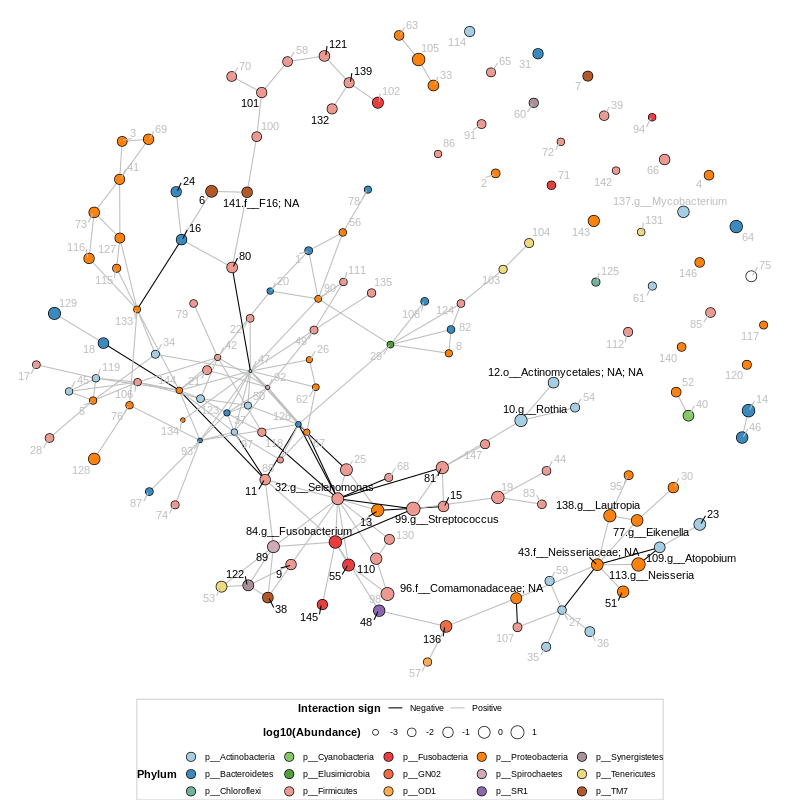

In [28]:
%%R -w 800 -h 800 -u px
print(par('din'))
set.seed(52) # For reprodicible layout of the graph
library(ggraph)
library(graphlayouts)
# Visualize the graph
#----------------------
# Display full labels of nodes with highest contribution to the first components
# of the compositional biplot
selected_vars <- sapply(rownames(asv16s_bactGenera_pca_vars_plot$data), 
                        function(x){as.numeric(strsplit(x,"\\.")[[1]][1])})
vars_colors <- rep("black",length(selected_vars))

# Labels for nodes
genus_labels_wtop10_andMyc <- seq(1,dim(genus_name)[1])
genus_labels_wtop10_andMyc[as.vector(selected_vars[1:10])] <- names(selected_vars[1:10])
#mycobacterium_ix <- grep("g__Mycobacterium",genus_name$label)
additional_ixs <- grep("g__Mycobacterium|g__Streptococcus|g__Neisseria", genus_name$label)
genus_labels_wtop10_andMyc[additional_ixs] <- genus_name$label[additional_ixs]

# Color for labels
genus_labels_colors <- rep("grey",length(genus_labels_wtop10_andMyc))
genus_labels_colors[as.vector(selected_vars)] <- "black"
unique_phyla <- sort(unique(igraph::V(asv16s_bacteria_genus.ig2)$Phylum))
nr_of_phyla <- length(unique_phyla)

asv16s_bacteria_genus.ig2.plot <- ggraph(asv16s_bacteria_genus.ig2, layout="fr") + 
                                     geom_edge_link0(aes(colour=factor(sign))) + 
                                     geom_node_point(aes(size=log10(Abundance), fill=Phylum), shape=21) + 
                                     geom_node_text(aes(label=genus_labels_wtop10_andMyc, 
                                                        colour=genus_labels_wtop10_andMyc),
                                                    point.padding = unit(0.20, "lines"), repel=TRUE) +
                                     scale_edge_colour_manual(name="Interaction sign", values=c("black","grey")) + 
                                     scale_fill_manual(name="Phylum",breaks=unique_phyla,
                                                       values=colorRampPalette(brewer.pal(12, "Paired"))(nr_of_phyla)) + 
                                     scale_colour_manual(name="Genus", limits=genus_labels_wtop10_andMyc,
                                                         labels=genus_name$label,
                                                         values=genus_labels_colors) +
                                     theme_void() + 
                                     guides(edge_colour=guide_legend(override.aes = list(size = 4), order=1), 
                                            size=guide_legend(order=2),
                                            alpha = guide_legend(override.aes = list(size = 4), order=3),
                                            fill=guide_legend(override.aes = list(size = 4), order=4),
                                            colour=guide_legend(title.position='top',order=5)) +
                                     theme(legend.position="bottom", legend.box = "vertical",
                                           legend.title=element_text(face="bold"),
                                           legend.box.background = element_rect(colour = "gray"))

asv16s_bacteria_genus.ig2.plot_file <- "./reports/figures/asv16s_bact_genus_network.svg"
ggsave(asv16s_bacteria_genus.ig2.plot_file, asv16s_bacteria_genus.ig2.plot, width=11.2, height=16.7)

asv16s_bacteria_genus.ig2.plot + guides(colour=FALSE)

**Panel with Compositional biplots and interaction netwroks**

[1] 16.66667 11.11111


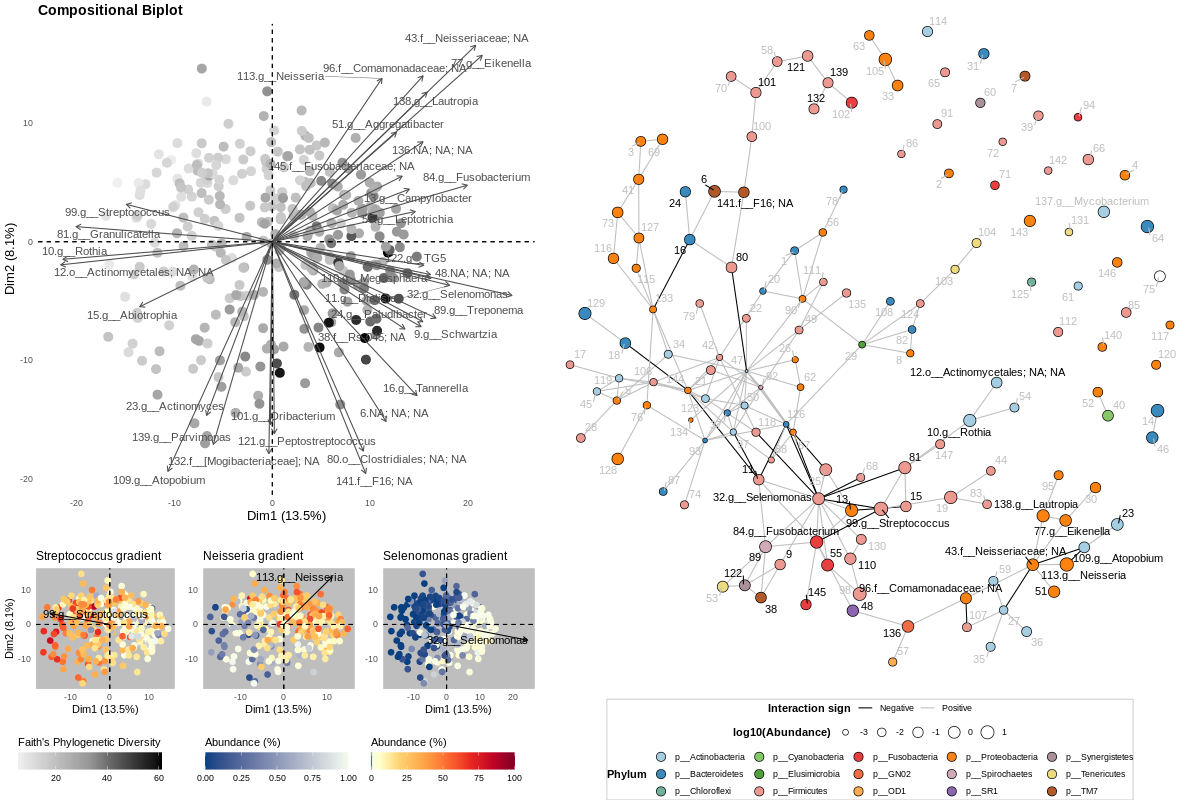

In [29]:
%%R -w 1200 -h 800 -u px
print(par('din'))
biplot_faith_legend <- cowplot::get_legend(asv16s_bactGenera_pca_biplot) 
biplot_abundance_legend <- cowplot::get_legend(asv16s_bactGenera_pca_biplot_ra_selenom)

pca_var_biplot_panel_layout <- rbind(c(1,1,1,7),
                                     c(1,1,1,7),
                                     c(2,3,4,7),
                                     c(5,6,6,7))
asv16S_bact_genus_biplot_network_panel <- grid.arrange(asv16s_bactGenera_pca_biplot + theme(legend.position="none"), 
                                                       asv16s_bactGenera_pca_biplot_ra_strepto + theme(legend.position="none"), 
                                                       asv16s_bactGenera_pca_biplot_ra_neisser + theme(axis.title.y=element_blank(),
                                                                                                       legend.position="none"),
                                                       asv16s_bactGenera_pca_biplot_ra_selenom + theme(axis.title.y=element_blank(),
                                                                                                       legend.position="none"),
                                                       biplot_faith_legend, biplot_abundance_legend,
                                                       layout_matrix=pca_var_biplot_panel_layout, 
                                                       asv16s_bacteria_genus.ig2.plot + guides(colour=FALSE),
                                                       heights=c(0.16,0.17,0.12,0.05), 
                                                       widths=c(0.15,0.15,0.15,0.55)
                                                      )

asv16S_bact_genus_biplot_network_panel_file <- "./reports/figures/asv16s_bact_genus_biplots_network.svg"
ggsave(asv16S_bact_genus_biplot_network_panel_file, asv16S_bact_genus_biplot_network_panel, 
       width=16.7, height=11.11)

### 2.5 Visualize the log-ratio variation of interacting genera

**Genera interacting with _Streptococcus_**

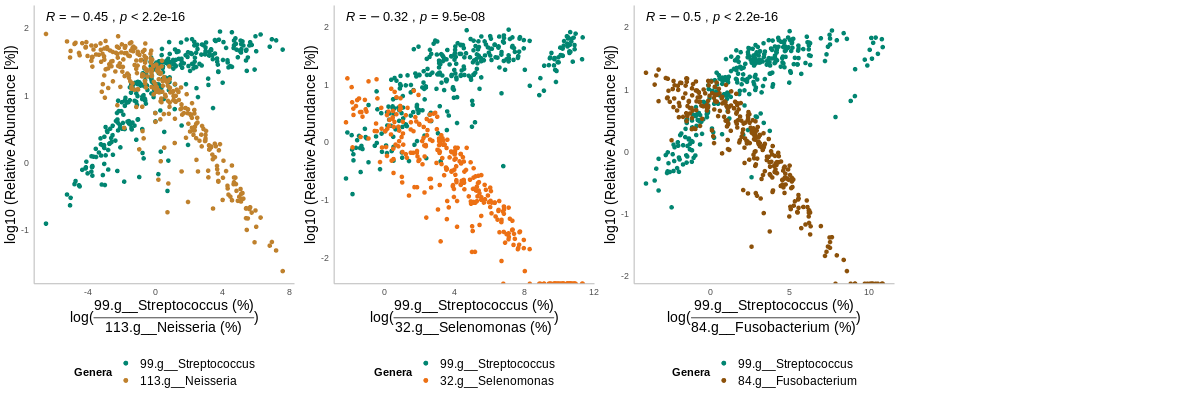

In [30]:
%%R -w 1200 -h 400
plot_interaction <- function(node1_id, node2_id, colors){
    log_node1_to_node2_ratio <- as.vector(asv16s_bacteria_genus_counts_clr[,node1_id] - 
                                         asv16s_bacteria_genus_counts_clr[,node2_id])
    node1_ra <- as.vector(asv16s_bacteria_genus_ra[rownames(asv16s_bacteria_genus_counts_clr),
                                                   node1_id])
    node2_ra <- as.vector(asv16s_bacteria_genus_ra[rownames(asv16s_bacteria_genus_counts_clr),
                                                   node2_id])
    node1_label <- paste0(genus_name[node1_id,"label"]," (%)")
    node2_label <- paste0(genus_name[node2_id,"label"]," (%)")
    
    temp_x_label <- expr(paste("log(", frac(!!node1_label,!!node2_label),")"))
    
    color_breaks <- c(genus_name[node1_id,"label"],genus_name[node2_id,"label"])
    color_breaks_values <- colors
    names(color_breaks_values) <- color_breaks
    
    node1_to_node2_scatter_plot <- ggplot() + 
                                   geom_point(aes(x=log_node1_to_node2_ratio,
                                                  y=log10(node1_ra), colour=genus_name[node1_id,"label"])) +
                                   geom_point(aes(x=log_node1_to_node2_ratio,
                                                  y=log10(node2_ra), colour=genus_name[node2_id,"label"])) + 
                                   stat_cor(aes(x=log10(node1_ra),y=log10(node2_ra)),method="pearson", cor.coef.name="R", 
                                            label.x = min(log_node1_to_node2_ratio), 
                                            label.y=max(c(log10(node1_ra),log10(node2_ra)))+0.2, 
                                            size=4.5, fontface="bold") +
                                   scale_colour_manual(name="Genera", 
                                                       breaks=color_breaks,
                                                       values=color_breaks_values) + 
                                   labs(x=temp_x_label, y="log10 (Relative Abundance [%])") +
                                   theme_minimal() + 
                                   theme(axis.title=element_text(size=14), 
                                         legend.text=element_text(size=12),
                                         legend.title = element_text(face="bold"), 
                                         legend.position = "bottom", 
                                         panel.grid.major = element_blank(),
                                         panel.grid.minor = element_blank(), 
                                         axis.line = element_line(color = "grey")) +
                                   guides(colour=guide_legend(nrow=2))
    return(node1_to_node2_scatter_plot)
}

streptococcus_id <- rownames(genus_name)[which(genus_name$Genus == "g__Streptococcus")]
neisseria_id <- rownames(genus_name)[which(genus_name$Genus == "g__Neisseria")]
selenomonas_id <- rownames(genus_name)[which(genus_name$Genus == "g__Selenomonas")]
fusobacterium_id <- rownames(genus_name)[which(genus_name$Genus == "g__Fusobacterium")]

#
streptococcus_neisse_plot <- plot_interaction(streptococcus_id, neisseria_id, colors=c("#018571","#bf812d"))

#
streptococcus_neighbors <- igraph::neighbors(asv16s_bacteria_genus.ig2, streptococcus_id)$name
streptococcus_neighbors_colors <- c("#f6e8c3","#ec7014","#c7eae5","#8c510a")
names(streptococcus_neighbors_colors) <- streptococcus_neighbors

streptococcus_neighb_plots <- list()
for (neighboor in streptococcus_neighbors){
    streptococcus_neighb_plots[[neighboor]] <- plot_interaction(streptococcus_id, neighboor, 
                                                                colors=c("#018571",
                                                                         streptococcus_neighbors_colors[[neighboor]] ))
}

grid.arrange(grobs=list(streptococcus_neisse_plot + guides(colour=guide_legend(nrow=2)),
                        streptococcus_neighb_plots[[selenomonas_id]] + guides(colour=guide_legend(nrow=2)),
                        streptococcus_neighb_plots[[fusobacterium_id]] + guides(colour=guide_legend(nrow=2))), 
             ncol=4, nrow=1)

[1] 6.666667 6.666667


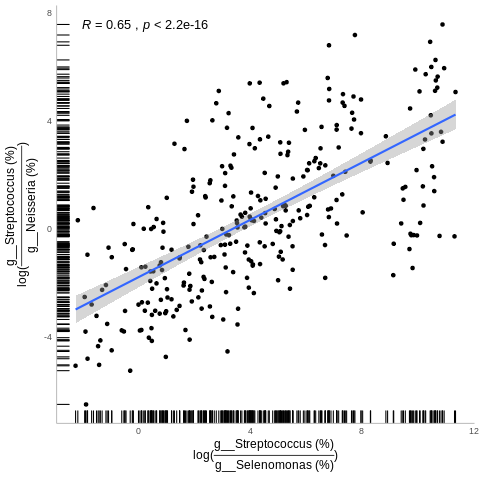

In [32]:
%%R
print(par('din'))
log_strepto_to_neisse_ratio <- as.vector(asv16s_bacteria_genus_counts_clr[,streptococcus_id] - 
                                         asv16s_bacteria_genus_counts_clr[,neisseria_id])
log_strepto_to_seleno_ratio <- as.vector(asv16s_bacteria_genus_counts_clr[,streptococcus_id] - 
                                         asv16s_bacteria_genus_counts_clr[,selenomonas_id])

temp_x_label <- expression(paste("log(", frac("g__Streptococcus (%)","g__Selenomonas (%)"),")"))
temp_y_label <- expression(paste("log(", frac("g__Streptococcus (%)","g__Neisseria (%)"),")"))

strep_seleno_and_strep_neiss_scatterplot <- ggplot(data=as.data.frame(asv16s_bacteria_genus_counts_clr), 
                                                   aes(x=log_strepto_to_seleno_ratio, 
                                                       y=log_strepto_to_neisse_ratio))+
                                            geom_point() +
                                            geom_rug() + 
                                            stat_cor(method="pearson", cor.coef.name="R", 
                                                     label.x = -2, label.y=7.5, size=4.5, fontface="bold") +
                                            geom_smooth(method=lm, fullrange=TRUE) + 
                                            labs(x=temp_x_label, y=temp_y_label) + 
                                            theme_minimal() + 
                                            theme(axis.title=element_text(size=12), 
                                                  panel.grid.major = element_blank(),
                                                  panel.grid.minor = element_blank(), 
                                                  axis.line = element_line(color = "grey"))
strep_seleno_and_strep_neiss_scatterplot

[1] 16.666667  4.166667


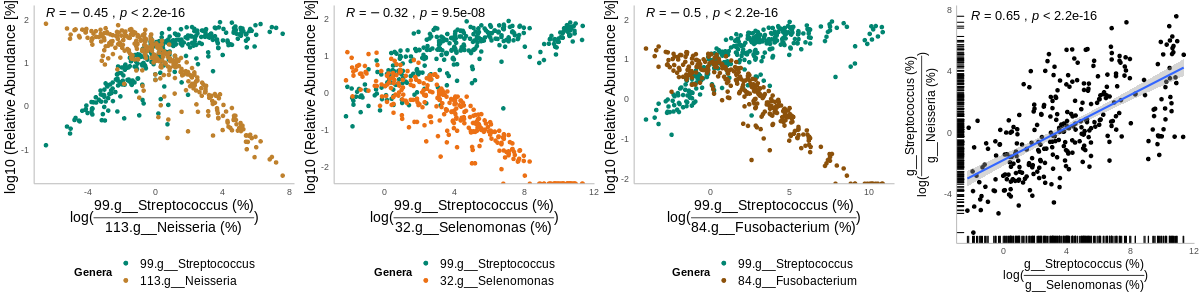

In [33]:
%%R -w 1200 -h 300
print(par('din'))
grid.arrange(grobs=list(streptococcus_neisse_plot + guides(colour=guide_legend(nrow=2)),
                        streptococcus_neighb_plots[[selenomonas_id]] + guides(colour=guide_legend(nrow=2)),
                        streptococcus_neighb_plots[[fusobacterium_id]] + guides(colour=guide_legend(nrow=2)), 
                        strep_seleno_and_strep_neiss_scatterplot), 
             ncol=4, nrow=1)

**Genera interacting with Selenomonas**

[1] 19.44444 20.83333


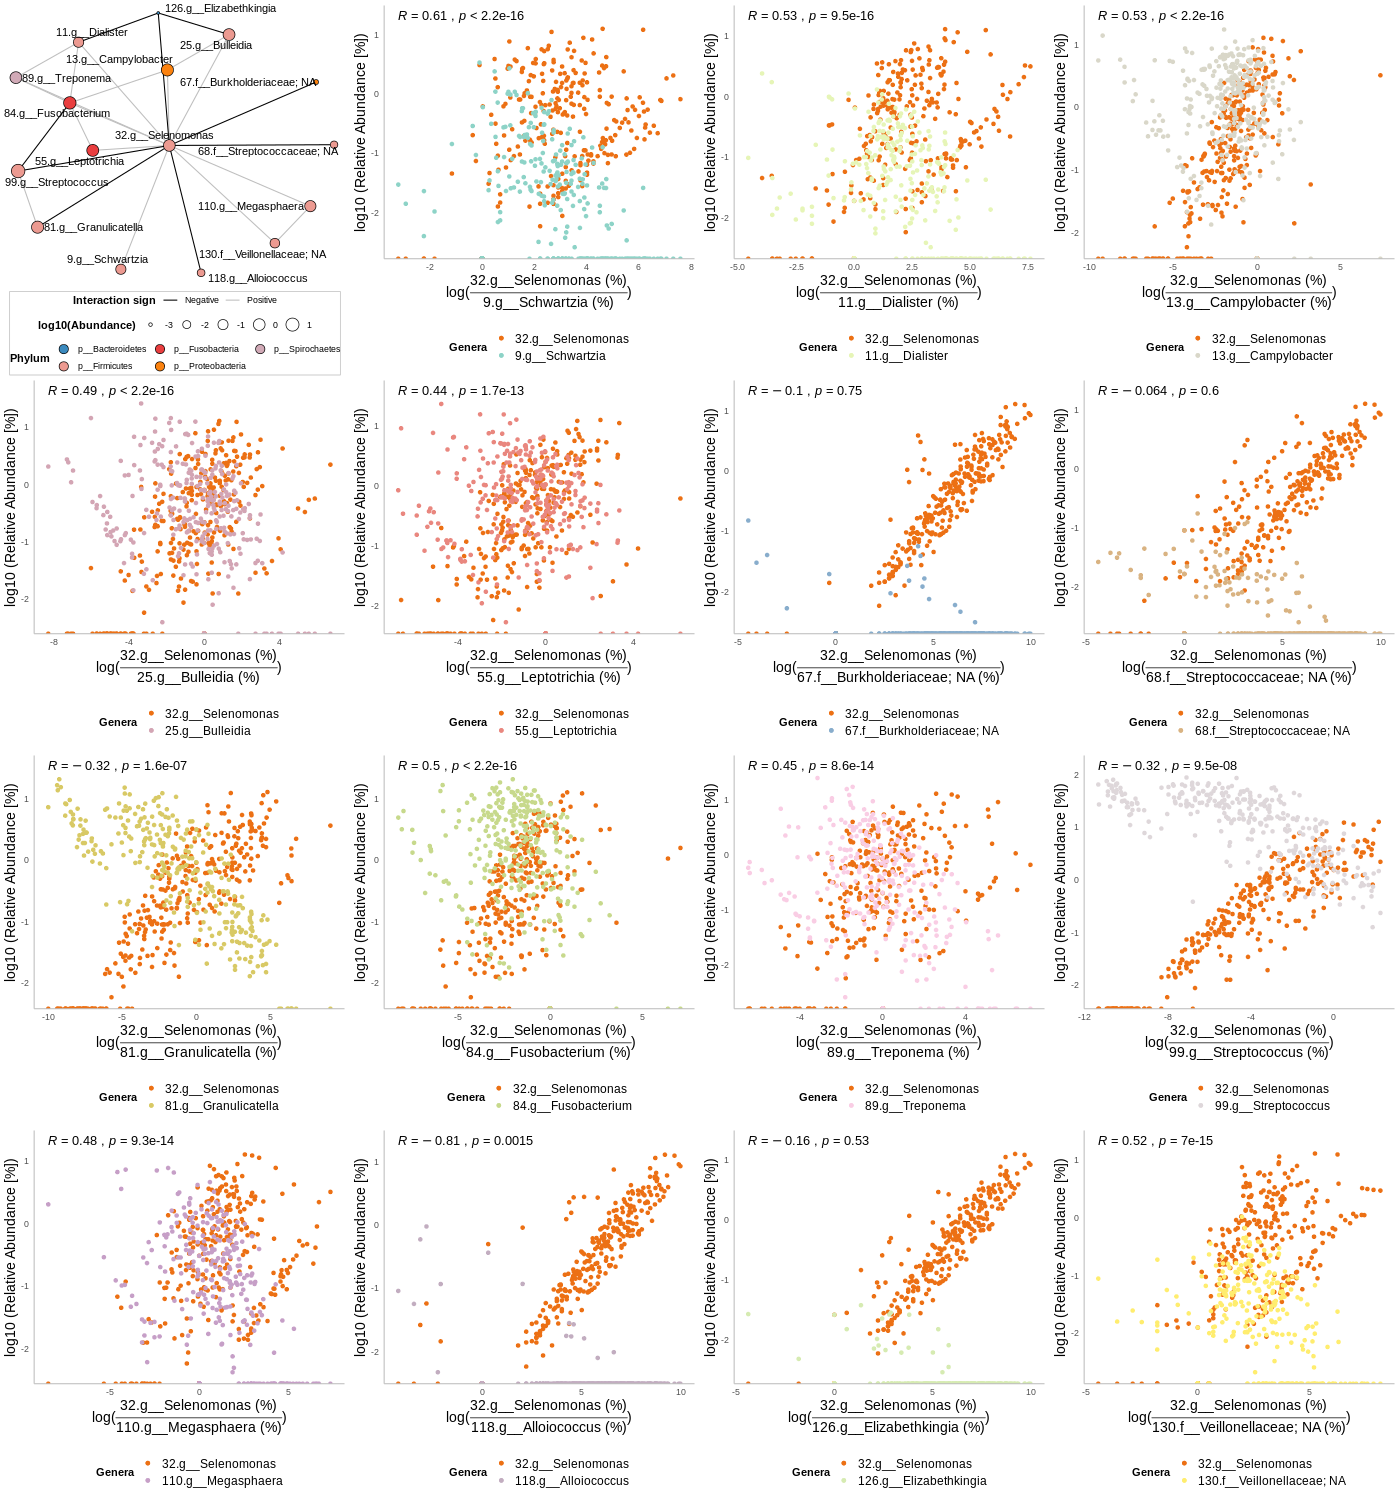

In [34]:
%%R -w 1400 -h 1500
print(par('din'))
# Genera interacting with selenomonas
selenomonas_neighbors <- igraph::neighbors(asv16s_bacteria_genus.ig2, selenomonas_id)$name

# Sub-graph of interactions with selenomonas
selenomonas_igraph <- igraph::subgraph(asv16s_bacteria_genus.ig2, c(selenomonas_id,selenomonas_neighbors))

asv16s_seleno_genus.ig2.plot <- ggraph(selenomonas_igraph, layout="fr") + 
                                     geom_edge_link0(aes(colour=factor(sign))) + 
                                     geom_node_point(aes(size=log10(Abundance), fill=Phylum), shape=21) + 
                                     geom_node_text(aes(label=label),colour="black",
                                                    point.padding = unit(0.20, "lines"), repel=TRUE) +
                                     scale_edge_colour_manual(name="Interaction sign", values=c("black","grey")) + 
                                     scale_fill_manual(name="Phylum",breaks=unique_phyla,
                                                       values=colorRampPalette(brewer.pal(12, "Paired"))(nr_of_phyla)) + 
                                     theme_void() + 
                                     guides(edge_colour=guide_legend(override.aes = list(size = 4), order=1), 
                                            size=guide_legend(order=2),
                                            alpha = guide_legend(override.aes = list(size = 4), order=3),
                                            fill=guide_legend(override.aes = list(size = 4), order=4, nrow=2)) +
                                     theme(legend.position="bottom", legend.box = "vertical",
                                           legend.title=element_text(face="bold"),
                                           legend.box.background = element_rect(colour = "gray"))

# PLoting abundance of selenomonas and other genera interacting with it
selenomonas_neighbors_colors <- colorRampPalette(brewer.pal(12, "Set3"))(length(selenomonas_neighbors))
names(selenomonas_neighbors_colors) <- selenomonas_neighbors
selenomonas_neighb_plots <- list()
for (neighboor in selenomonas_neighbors){
    selenomonas_neighb_plots[[neighboor]] <- plot_interaction(selenomonas_id, 
                                                              neighboor, 
                                                              colors=c("#ec7014",
                                                                       selenomonas_neighbors_colors[[neighboor]] ))
}

asv16S_seleno_genus_interactions_panel <- grid.arrange(grobs=append(list(asv16s_seleno_genus.ig2.plot),
                                                                    selenomonas_neighb_plots))

asv16S_seleno_genus_interactions_panel_file <- "./reports/figures/asv16s_selenomonas_interactions.svg"
ggsave(asv16S_seleno_genus_interactions_panel_file, asv16S_seleno_genus_interactions_panel, 
       width=19.44, height=20.833)


## 3. Evaluating the relationship of microbial interactions with phylogenetic diversity (PD)

Multiple studies of ecological communities have shown that the strength of interactions between members of a community can determine the structure and diversity of the community \[<cite data-cite="2542765/GQF8NJJ3"></cite> <cite data-cite="2542765/PLHNV85I"></cite>\]. Thus, we hypothesized that the strength of the _Streptococcus-Selenomonas_ interaction within individual assemblages might have an impact on diversity. Consequently, for each sputum sample, we measured the strength of the antagonistic interaction between these two genera as the absolute value of the log-ratio of their abundances. Large values indicate large differences in their relative abundance and therefore large antagonistic effects of one taxon on the other, while small values indicate co-existence and therefore weak antagonism. To measure diversity within individual microbial assemblages, we computed Faith's phylogenetic diversity (PD). We found a negative correlation between PD and the strength of the _Streptococcus-Selenomonas_ interaction (rho=-0.62, p<0.001). Consisting with a recent study <cite data-cite="2542765/PLHNV85I"></cite>, this result suggest that a strong _Streptococcus-Selenomonas_ interaction in sputum microbial assemblages impacts negatively the diversity of the community.

**Relationship between the strength of the Streptococcus-Selenomonas interaction and Phylogenetic diversity**

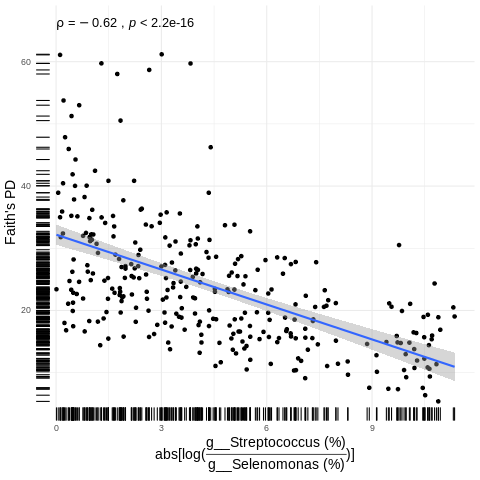

In [35]:
%%R
log_strepto_to_seleno_ratio <- as.vector(asv16s_bacteria_genus_counts_clr[,streptococcus_id] - 
                                         asv16s_bacteria_genus_counts_clr[,selenomonas_id])

faithpd <- faithpd_table[rownames(asv16s_bacteria_genus_counts_clr),]
seq_depth <- asv16s_stats[rownames(asv16s_bacteria_genus_counts_clr),"non.chimeric"]

temp_x_label <- expression(paste("abs[log(", frac("g__Streptococcus (%)","g__Selenomonas (%)"),")]"))
strep_selen_and_faith_scatter <- ggplot() + 
                                 geom_point(aes(x=abs(log_strepto_to_seleno_ratio), y=faithpd)) + 
                                 geom_rug(aes(x=abs(log_strepto_to_seleno_ratio), y=faithpd)) + 
                                 geom_smooth(aes(x=abs(log_strepto_to_seleno_ratio), y=faithpd), 
                                             method=lm, fullrange=TRUE) + 
                                 #scale_color_manual(name="Underweight",values=c('#7fbf7b', '#762a83')) +
                                 #scale_fill_manual(name="Underweight",values=c('#7fbf7b', '#762a83')) + 
                                 #scale_shape_manual(name="Underweight", values=c(16,16)) +
                                 stat_cor(aes(x=abs(log_strepto_to_seleno_ratio), y=faithpd), 
                                          method="spearman", cor.coef.name="rho", 
                                          label.x = 0, label.y=66, size=4.5, fontface="bold") + 
                                 labs(x=temp_x_label, y="Faith's PD") + 
                                 theme_minimal() + 
                                 theme(legend.position="none", 
                                       legend.title=element_text(face="bold"), 
                                       axis.title=element_text(size=14))
strep_selen_and_faith_scatter

**Relationship between the strength of the Streptococcus-Fusobacterium interaction and Phylogenetic diversity**

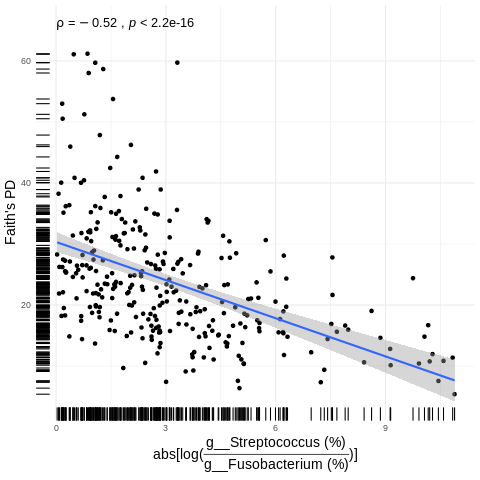

In [36]:
%%R
log_strepto_to_fusoba_ratio <- as.vector(asv16s_bacteria_genus_counts_clr[,streptococcus_id] - 
                                         asv16s_bacteria_genus_counts_clr[,fusobacterium_id])
temp_label <- expression(paste("abs[log(", frac("g__Streptococcus (%)","g__Fusobacterium (%)"),")]"))
strep_fusoba_and_faith_scatter <- ggplot() + 
                                 geom_point(aes(x=abs(log_strepto_to_fusoba_ratio), y=faithpd)) + 
                                 geom_rug(aes(x=abs(log_strepto_to_fusoba_ratio), y=faithpd)) + 
                                 geom_smooth(aes(x=abs(log_strepto_to_fusoba_ratio), y=faithpd), 
                                             method=lm, fullrange=TRUE) + 
                                 stat_cor(aes(x=abs(log_strepto_to_fusoba_ratio), y=faithpd), 
                                          method="spearman", cor.coef.name="rho", 
                                          label.x = 0, label.y=66, size=4.5, fontface="bold") + 
                                 labs(x=temp_label, y="Faith's PD") + 
                                 theme_minimal() + 
                                 theme(legend.position="none", 
                                       legend.title=element_text(face="bold"), 
                                       axis.title=element_text(size=14))
strep_fusoba_and_faith_scatter

## 4. Phylogenetic diversity and the accumulation of non-interacting genera

The genus-level interaction network revealed a group of isolated nodes in the network. These isolated nodes represent genera whose presence is not consistent across all sputum samples or whose abundance was not associated to the abundance of other genera. These genera belonged to different phyla, we therefore hypothesized that accumulation of this genera within a sample will increase Faith's Phylogenetic diversity.

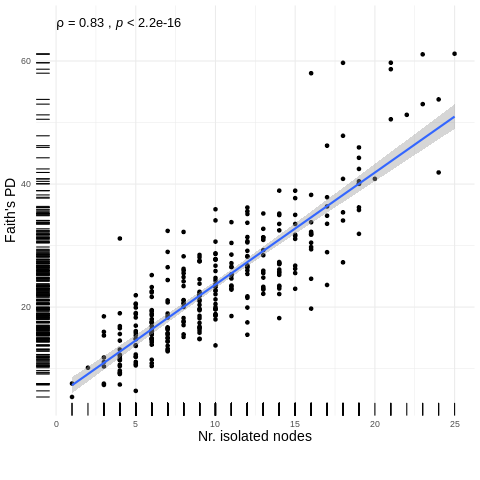

In [37]:
%%R
genus_nodes_d0 <- names(which(igraph::degree(asv16s_bacteria_genus.ig2) <1))
genus_nodes_d0_presence_freq <- colSums(asv16s_bacteria_genus_ra[,genus_nodes_d0] >0)
genus_nodes_d0_presence_freq_persample <- rowSums(asv16s_bacteria_genus_ra[rownames(asv16s_bacteria_genus_counts_clr),
                                                                           genus_nodes_d0] >0)

faith_and_nodesD0_scatter <- ggplot() + 
                                 geom_point(aes(x=abs(genus_nodes_d0_presence_freq_persample), y=faithpd)) + 
                                 geom_rug(aes(x=genus_nodes_d0_presence_freq_persample, y=faithpd)) + 
                                 geom_smooth(aes(x=genus_nodes_d0_presence_freq_persample, y=faithpd), 
                                             method=lm, fullrange=TRUE) + 
                                 stat_cor(aes(x=genus_nodes_d0_presence_freq_persample, y=faithpd), 
                                          method="spearman", cor.coef.name="rho", 
                                          label.x = 0, label.y=66, size=4.5, fontface="bold") + 
                                 labs(x="Nr. isolated nodes\n\n", y="Faith's PD") + 
                                 theme_minimal() + 
                                 theme(legend.position="none", 
                                       legend.title=element_text(face="bold"), 
                                       axis.title=element_text(size=14))
faith_and_nodesD0_scatter

# cor.test(faithpd, 
#          genus_nodes_d0_presence_freq_persample[rownames(asv16s_bacteria_genus_counts_clr)])

We indeed found that accumulation of isolated nodes in sputum samples was positively correlated with PD.

## 5. Accumulation of non-interacting genera and the strength of the _Streptococcus_-_Selenomonas_ interaction

Consisting with our finding that PD was negatively correlated with the strength of the _Streptococcus-Selenomonas_ interaction, we also found a negative correlation between the later and the accumulation of these potentially transient genera.

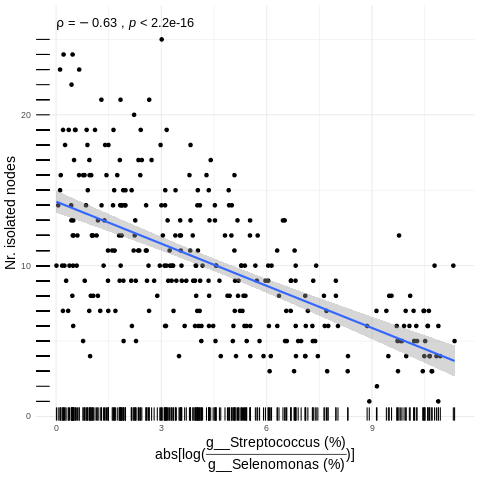

In [38]:
%%R
temp_x_label <- expression(paste("abs[log(", frac("g__Streptococcus (%)","g__Selenomonas (%)"),")]"))
strep_selen_and_nodesd0_scatter <- ggplot() + 
                                 geom_point(aes(x=abs(log_strepto_to_seleno_ratio), 
                                                y=genus_nodes_d0_presence_freq_persample)) + 
                                 geom_rug(aes(x=abs(log_strepto_to_seleno_ratio), 
                                              y=genus_nodes_d0_presence_freq_persample)) + 
                                 geom_smooth(aes(x=abs(log_strepto_to_seleno_ratio), 
                                                 y=genus_nodes_d0_presence_freq_persample), 
                                             method=lm, fullrange=TRUE) + 
                                 stat_cor(aes(x=abs(log_strepto_to_seleno_ratio), 
                                              y=genus_nodes_d0_presence_freq_persample), 
                                          method="spearman", cor.coef.name="rho", 
                                          label.x = 0, label.y=26, size=4.5, fontface="bold") + 
                                 labs(x=temp_x_label, y="Nr. isolated nodes") + 
                                 theme_minimal() + 
                                 theme(legend.position="none", 
                                       legend.title=element_text(face="bold"), 
                                       axis.title=element_text(size=14))
strep_selen_and_nodesd0_scatter

## 6. Panel of relationships between phylogenetic diversity, interactions and accumulation of isolated nodes

[1] 16.666667  4.166667


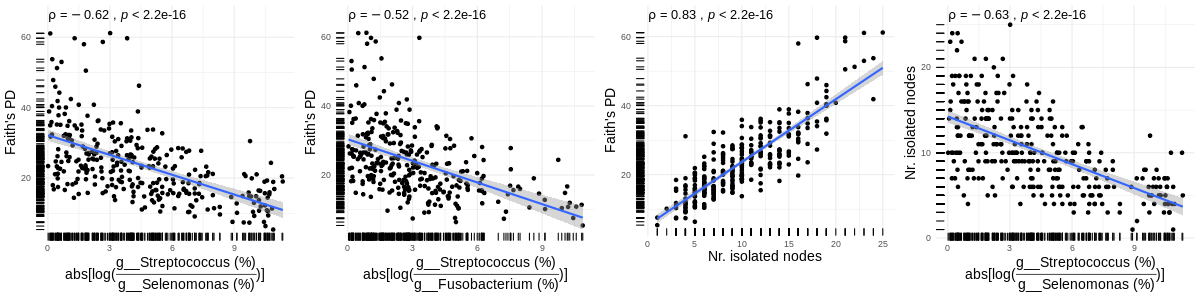

In [39]:
%%R -w 1200 -h 300
print(par('din'))
grid.arrange(strep_selen_and_faith_scatter, strep_fusoba_and_faith_scatter, 
             faith_and_nodesD0_scatter, strep_selen_and_nodesd0_scatter, ncol=4)

## 7. Panel of compositional biplot, interaction network and relationships with phylogenetic diversity

[1] 16.66667 19.44444


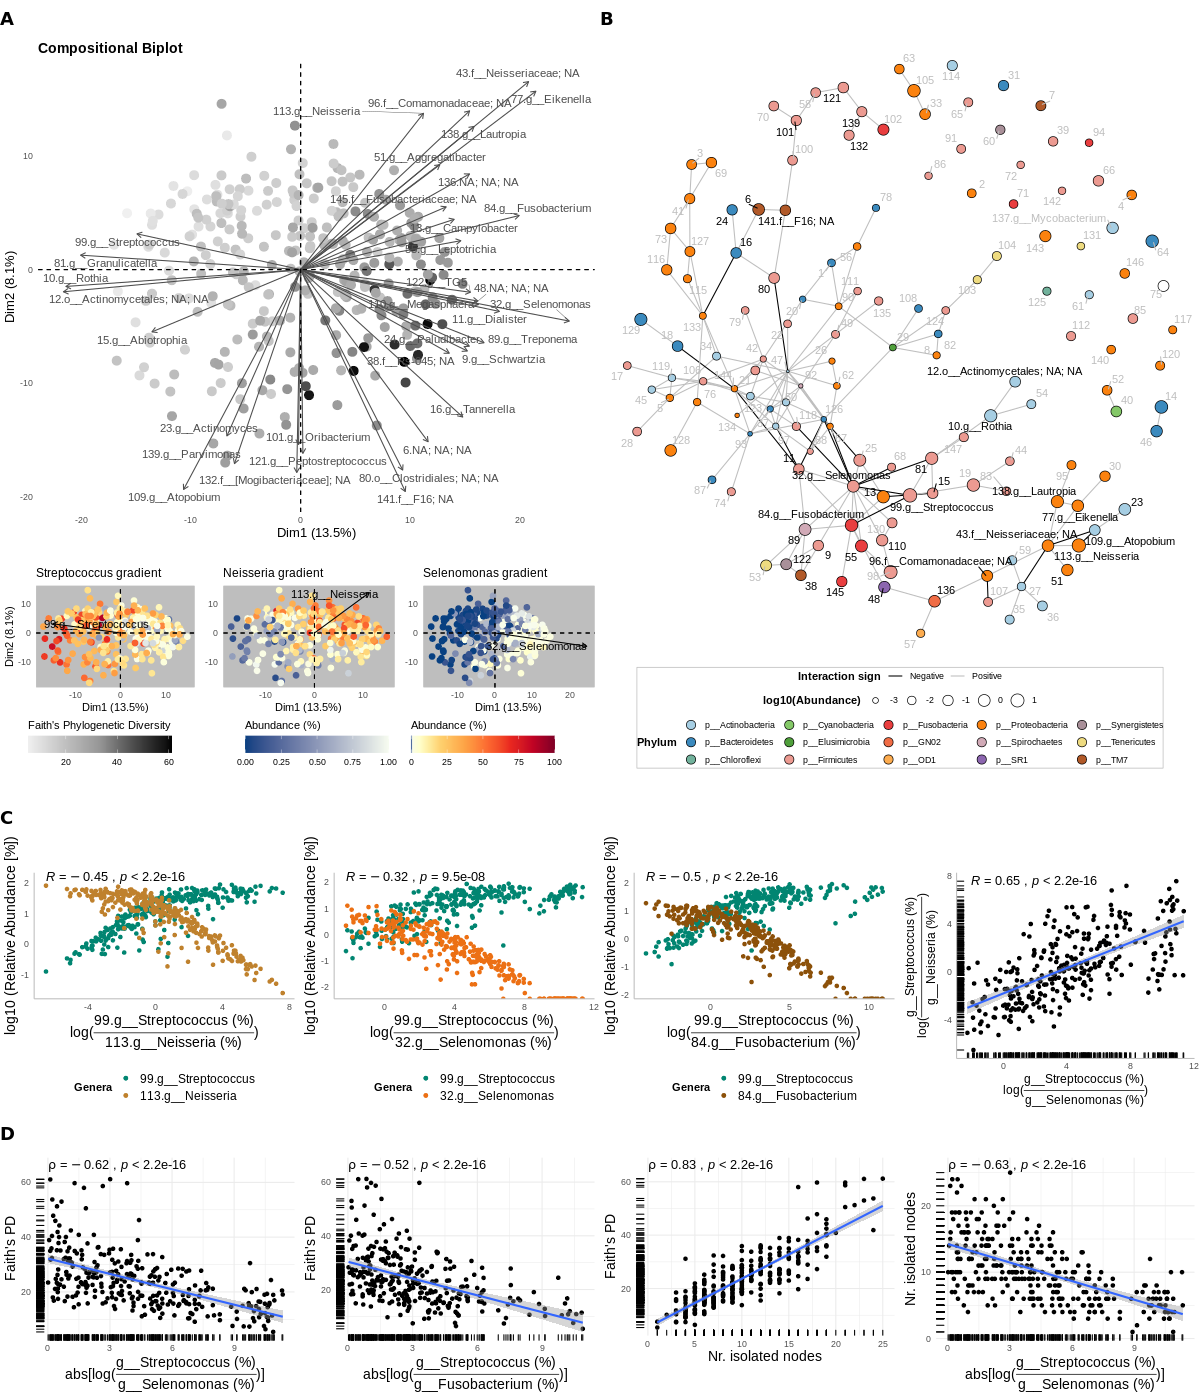

In [41]:
%%R -w 1200 -h 1400
print(par('din'))
biplot_faith_legend <- cowplot::get_legend(asv16s_bactGenera_pca_biplot) 
biplot_abundance_legend <- cowplot::get_legend(asv16s_bactGenera_pca_biplot_ra_selenom)

biplot_network_int_panel_layout <- rbind(c(16,16,16,16,16,16,17,17,17,17,17,17),
                                         c(1,1,1,1,1,1,7,7,7,7,7,7),
                                         c(1,1,1,1,1,1,7,7,7,7,7,7),
                                         c(2,2,3,3,4,4,7,7,7,7,7,7),
                                         c(5,5,6,6,6,6,7,7,7,7,7,7),
                                         c(18,18,18,18,18,18,18,18,18,18,18,18),
                                         c(8,8,8,9,9,9,10,10,10,11,11,11),
                                         c(19,19,19,19,19,19,19,19,19,19,19,19),
                                         c(12,12,12,13,13,13,14,14,14,15,15,15))

biplot_network_int_panel <- grid.arrange(asv16s_bactGenera_pca_biplot + theme(legend.position="none"), 
                                         asv16s_bactGenera_pca_biplot_ra_strepto + theme(legend.position="none"), 
                                         asv16s_bactGenera_pca_biplot_ra_neisser + theme(axis.title.y=element_blank(),
                                                                                         legend.position="none"),
                                         asv16s_bactGenera_pca_biplot_ra_selenom + theme(axis.title.y=element_blank(),
                                                                                         legend.position="none"),
                                         biplot_faith_legend, biplot_abundance_legend,
                                         asv16s_bacteria_genus.ig2.plot + guides(colour=FALSE),
                                         streptococcus_neisse_plot,
                                         streptococcus_neighb_plots[[selenomonas_id]], 
                                         streptococcus_neighb_plots[[fusobacterium_id]], 
                                         strep_seleno_and_strep_neiss_scatterplot,
                                         strep_selen_and_faith_scatter,
                                         strep_fusoba_and_faith_scatter,
                                         faith_and_nodesD0_scatter,
                                         strep_selen_and_nodesd0_scatter,
                                         textGrob("A",just="left", x=unit(0, "npc"), 
                                                  gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                         textGrob("B",just="left", x=unit(0, "npc"), 
                                                  gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                         textGrob("C",just="left", x=unit(0, "npc"),
                                                  gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                         textGrob("D",just="left", x=unit(0, "npc"), 
                                                  gp=gpar(fontfamily="Roboto Condensed",fontsize=18, fontface="bold")),
                                         layout_matrix=biplot_network_int_panel_layout,
                                         heights=c(0.03,0.20,0.21,0.14,0.04,0.08,0.2,0.03,0.2), 
                                         widths=c(0.08,0.08,0.08,0.08,0.08,0.08,
                                                  0.08,0.08,0.08,0.08,0.08,0.08)
                                        )
asv16S_biplot_network_interactions_panel_file <- "./reports/figures/asv16s_biplot_network_interactions.svg"
asv16S_biplot_network_interactions_panel_pdf_file <- "./reports/figures/asv16s_biplot_network_interactions.pdf"
ggsave(asv16S_biplot_network_interactions_panel_file, biplot_network_int_panel, width=16.67, height=19.44)
ggsave(asv16S_biplot_network_interactions_panel_pdf_file, biplot_network_int_panel, width=16.67, height=19.44, 
       dpi=300, device=cairo_pdf)

## 8. Simultaneous visualization of the abundance relationships among genera _Streptococcus_, _Neisseria_, _Selenomonas_, and _Fusobacterium_

In [42]:
%%R
streptococcus_id <- rownames(genus_name)[which(genus_name$Genus == "g__Streptococcus")]
neisseria_id <- rownames(genus_name)[which(genus_name$Genus == "g__Neisseria")]
selenomonas_id <- rownames(genus_name)[which(genus_name$Genus == "g__Selenomonas")]
fusobacterium_id <- rownames(genus_name)[which(genus_name$Genus == "g__Fusobacterium")]

asv16s_bacteria_subset_genus_ra <- asv16s_bacteria_genus_ra[rownames(asv16s_bacteria_genus_counts_clr),
                                                            c(streptococcus_id,neisseria_id,selenomonas_id,fusobacterium_id)]

asv16s_bacteria_subset_genus_ra_other <- 100 - rowSums(asv16s_bacteria_subset_genus_ra)

asv16s_bacteria_subset_genus_ra_toplot <- psmelt(asv16s_bacteria_subset_genus_ra)

asv16s_bacteria_subset_genus_ra_toplot <- rbind(asv16s_bacteria_subset_genus_ra_toplot, 
                                                data.frame("OTU" = rep("other",nrow(asv16s_bacteria_subset_genus_ra)), 
                                                           "Sample" = names(asv16s_bacteria_subset_genus_ra_other), 
                                                           "Abundance" = as.vector(asv16s_bacteria_subset_genus_ra_other)), 
                                                make.row.names = FALSE)
asv16s_bacteria_subset_genus_ra_toplot$OTU <- factor(asv16s_bacteria_subset_genus_ra_toplot$OTU, 
                                                     levels = rev(c(streptococcus_id,neisseria_id,selenomonas_id,fusobacterium_id,"other")), 
                                                     labels= rev(c("g__Streptococcus","g__Neisseria","g__Selenomonas","g__Fusobacterium","Other")))

dim(asv16s_bacteria_subset_genus_ra_toplot)

[1] 1535    3


Lets sort the samples by hierarchical clustering of centred log-ratio transformed abundances of the four genera:

In [43]:
%%R
library(dendsort)
# Aitchison distances on CLR-transformed data
# --------------------------------------------
asv16s_bactGenera_subset_samples_pairwise_dist <- dist(asv16s_bacteria_genus_counts_clr[,c(streptococcus_id,neisseria_id,selenomonas_id,fusobacterium_id)])

# Cluster and reorder samples based on Aitchison distances
sort_hclust <- function(...) as.hclust(dendsort(as.dendrogram(...), isReverse = FALSE))
asv16s_bacteria_genus_cluster_samples <- sort_hclust(hclust(asv16s_bactGenera_subset_samples_pairwise_dist))

Lets create the barplots of the relative abundances:

[1] 16.666667  8.333333


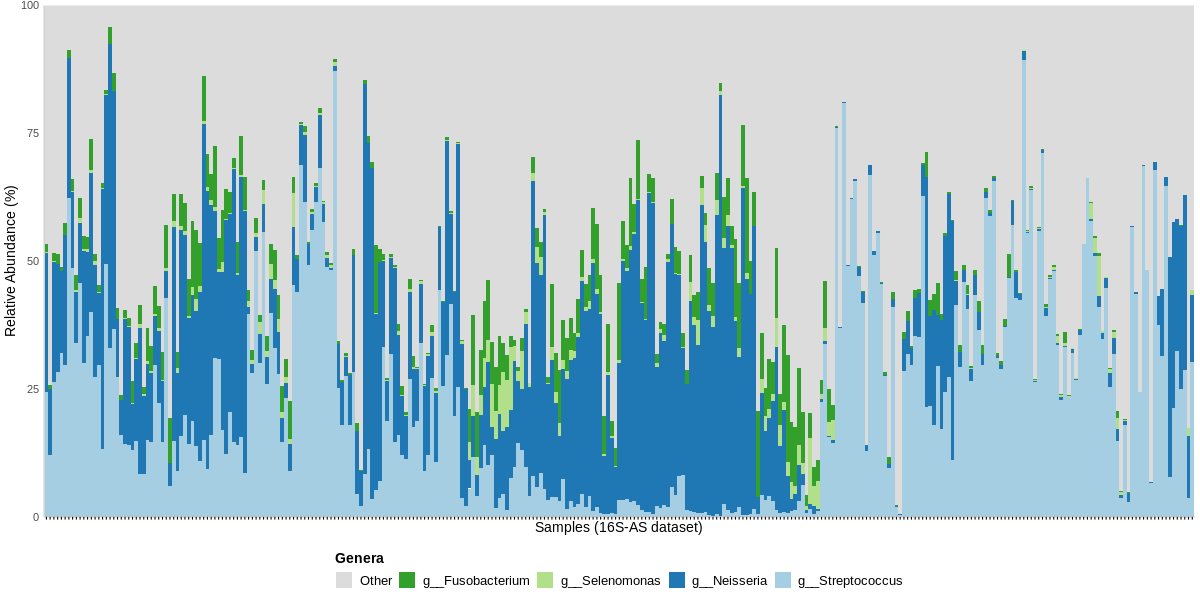

In [44]:
%%R -w 1200 -h 600
print(par('din'))
asv16s_genera_subset_barplot  <- ggplot(asv16s_bacteria_subset_genus_ra_toplot, 
                                        aes(x=factor(Sample, 
                                                     levels=asv16s_bacteria_genus_cluster_samples$labels[asv16s_bacteria_genus_cluster_samples$order]), 
                                            y=Abundance, fill=OTU))

genus_colors <- c("Other"="#DCDCDC","g__Streptococcus"="#a6cee3","g__Neisseria"="#1f78b4",
                  "g__Selenomonas"="#b2df8a","g__Fusobacterium"="#33a02c")

asv16s_genera_subset_barplot <- asv16s_genera_subset_barplot + 
                                 geom_bar(stat="identity", position="stack", width=1) + 
                                 scale_fill_manual(values=genus_colors, name="Genera") + 
                                 scale_y_continuous(expand = c(0,0)) +
                                 labs(x="Samples (16S-AS dataset)", y="Relative Abundance (%)") +
                                 theme_minimal() + 
                                 theme(axis.title=element_text(size=14), 
                                       legend.text=element_text(size=13),
                                       legend.title = element_text(face="bold", size=14), 
                                       legend.position = "bottom", 
                                       panel.grid.major = element_blank(),
                                       panel.grid.minor = element_blank(), 
                                       axis.line = element_line(colour = "grey"), 
                                       axis.text.x=element_blank(),
                                       axis.text.y=element_text(size=11),
                                       axis.ticks.x = element_line(),
                                      ) + 
                                 guides(fill=guide_legend(title.position = "top"))
print(asv16s_genera_subset_barplot)


asv16s_genera_subset_barplot_file <- "./reports/figures/asv16s_genera_strepto_neiss_seleno_fuso_barplot.svg"
asv16s_genera_subset_barplot_pdf_file <- "./reports/figures/asv16s_genera_strepto_neiss_seleno_fuso_barplot.pdf"
ggsave(asv16s_genera_subset_barplot_file, asv16s_genera_subset_barplot, width=16.67, height=8.33)
ggsave(asv16s_genera_subset_barplot_pdf_file, asv16s_genera_subset_barplot, width=16.67, height=8.33, 
       dpi=300, device=cairo_pdf)